In [1]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import fiona
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from geofeather import to_geofeather, from_geofeather
%matplotlib inline

# Import CONABIO Bathy points (4m) overlayed with TNC bathy raster (10m)

In [2]:
# Working Directory
work_dir = '/Users/arbailey/natcap/idb/data/work/bathy'
os.chdir(work_dir)

In [3]:
# Import the previously joined point file layer (with SRTM & mangrove extents) into GeoDataFrame 
%time bathy_conabio_tncMARnorth = from_geofeather('bathy_conabio_tncMARnorth.feather')
bathy_conabio_tncMARnorth

CPU times: user 7min 57s, sys: 17.7 s, total: 8min 15s
Wall time: 8min 21s


,index,depth_m,x_utm16n,y_utm16n,geometry,tncdep_m,tncdep_idx
0,8551850,-1.8,521824.0,2363194.0,POINT (-86.78949 21.37074),0.0,11469
1,8551851,-1.8,521828.0,2363194.0,POINT (-86.78945 21.37074),0.0,11470
2,8551852,-1.8,521832.0,2363194.0,POINT (-86.78941 21.37074),0.0,11470
3,8551853,-1.9,521836.0,2363194.0,POINT (-86.78937 21.37074),0.0,11471
4,8551854,-2.0,521840.0,2363194.0,POINT (-86.78933 21.37074),0.0,11471
...,...,...,...,...,...,...,...
47330941,55882845,-15.8,433396.0,2086546.0,POINT (-87.63232 18.86985),0.0,420343148
47330942,55882846,-16.0,433400.0,2086546.0,POINT (-87.63228 18.86985),0.0,420343148
47330943,55882847,-16.5,433404.0,2086546.0,POINT (-87.63224 18.86985),0.0,420343149
47330944,55882848,-17.0,433408.0,2086546.0,POINT (-87.63220 18.86985),0.0,420343149


In [4]:
bathy_conabio_tncMARnorth['conabiodep_m'] = bathy_conabio_tncMARnorth['depth_m'] * (-1)
bathy_conabio_tncMARnorth

,index,depth_m,x_utm16n,y_utm16n,geometry,tncdep_m,tncdep_idx,conabiodep_m
0,8551850,-1.8,521824.0,2363194.0,POINT (-86.78949 21.37074),0.0,11469,1.8
1,8551851,-1.8,521828.0,2363194.0,POINT (-86.78945 21.37074),0.0,11470,1.8
2,8551852,-1.8,521832.0,2363194.0,POINT (-86.78941 21.37074),0.0,11470,1.8
3,8551853,-1.9,521836.0,2363194.0,POINT (-86.78937 21.37074),0.0,11471,1.9
4,8551854,-2.0,521840.0,2363194.0,POINT (-86.78933 21.37074),0.0,11471,2.0
...,...,...,...,...,...,...,...,...
47330941,55882845,-15.8,433396.0,2086546.0,POINT (-87.63232 18.86985),0.0,420343148,15.8
47330942,55882846,-16.0,433400.0,2086546.0,POINT (-87.63228 18.86985),0.0,420343148,16.0
47330943,55882847,-16.5,433404.0,2086546.0,POINT (-87.63224 18.86985),0.0,420343149,16.5
47330944,55882848,-17.0,433408.0,2086546.0,POINT (-87.63220 18.86985),0.0,420343149,17.0


In [5]:
bathy_conabio_tncMARnorth.describe()

,index,depth_m,x_utm16n,y_utm16n,tncdep_m,tncdep_idx,conabiodep_m
count,4.733095e+07,4.733095e+07,4.733095e+07,4.733095e+07,4.733095e+07,4.733095e+07,4.733095e+07
mean,3.221732e+07,-5.851190e+00,4.748884e+05,2.224343e+06,4.943521e+00,2.109359e+08,5.851190e+00
std,1.366327e+07,4.490235e+00,3.216915e+04,8.186158e+04,4.751160e+00,1.243734e+08,4.490235e+00
min,8.551850e+06,-2.300000e+01,4.323480e+05,2.086546e+06,0.000000e+00,1.146900e+04,1.000000e-01
25%,2.038459e+07,-7.400000e+00,4.512240e+05,2.156230e+06,1.004592e+00,8.208898e+07,2.700000e+00
50%,3.221732e+07,-4.400000e+00,4.552720e+05,2.189306e+06,3.378043e+00,2.641761e+08,4.400000e+00
75%,4.405006e+07,-2.700000e+00,5.154760e+05,2.309138e+06,7.579882e+00,3.143959e+08,7.400000e+00
max,5.588285e+07,-1.000000e-01,5.306640e+05,2.363194e+06,3.000000e+01,4.203432e+08,2.300000e+01


In [6]:
# Subset to remove TNC No Data areas (0)
bathy_conabio_tncMARnorth_nozero = bathy_conabio_tncMARnorth[(bathy_conabio_tncMARnorth['tncdep_m'] > 0)]
bathy_conabio_tncMARnorth_nozero

,index,depth_m,x_utm16n,y_utm16n,geometry,tncdep_m,tncdep_idx,conabiodep_m
221669,8773519,-2.700000,522980.0,2361754.0,POINT (-86.77836 21.35772),2.374527,2200948,2.700000
221670,8773520,-2.800000,522984.0,2361754.0,POINT (-86.77832 21.35772),1.207622,2200949,2.800000
221671,8773521,-2.800000,522988.0,2361754.0,POINT (-86.77828 21.35772),1.207622,2200949,2.800000
221672,8773522,-2.800000,522992.0,2361754.0,POINT (-86.77824 21.35772),0.550085,2200950,2.800000
221673,8773523,-2.800000,522996.0,2361754.0,POINT (-86.77820 21.35772),0.550085,2200950,2.800000
...,...,...,...,...,...,...,...,...
47132240,55684090,-17.000000,434292.0,2089238.0,POINT (-87.62390 18.89421),20.045877,416251413,17.000000
47132241,55684091,-17.299999,434296.0,2089238.0,POINT (-87.62386 18.89421),20.045877,416251413,17.299999
47132242,55684092,-17.700001,434300.0,2089238.0,POINT (-87.62383 18.89421),20.540062,416251414,17.700001
47132243,55684093,-17.700001,434304.0,2089238.0,POINT (-87.62379 18.89421),20.540062,416251414,17.700001


In [60]:
bathy_conabio_tncMARnorth_nozero.describe()

,index,depth_m,x_utm16n,y_utm16n,tncdep_m,tncdep_idx,conabiodep_m
count,4.581342e+07,4.581342e+07,4.581342e+07,4.581342e+07,4.581342e+07,4.581342e+07,4.581342e+07
mean,3.224631e+07,-5.978772e+00,4.748524e+05,2.224120e+06,5.107271e+00,2.112741e+08,5.978772e+00
std,1.355289e+07,4.488678e+00,3.208872e+04,8.128540e+04,4.741828e+00,1.234976e+08,4.488678e+00
min,8.773519e+06,-2.300000e+01,4.328560e+05,2.089238e+06,2.623740e-06,2.200819e+06,1.000000e-01
25%,2.042364e+07,-7.700000e+00,4.512640e+05,2.156874e+06,1.229708e+00,8.246634e+07,2.800000e+00
50%,3.240729e+07,-4.500000e+00,4.552440e+05,2.188522e+06,3.546319e+00,2.653688e+08,4.500000e+00
75%,4.398170e+07,-2.800000e+00,5.153680e+05,2.308890e+06,7.762378e+00,3.134144e+08,7.700000e+00
max,5.568409e+07,-1.000000e-01,5.306640e+05,2.361754e+06,3.000000e+01,4.162514e+08,2.300000e+01


In [61]:
# GRoup Data frame with some summary stats on CONABIO depth by TNC cell
def grouped_summary(pts_gdf, grouping_cols=['tncdep_idx','tncdep_m']):
    grouped_df = pts_gdf.groupby(
        grouping_cols
    ).agg(
        max_z = ('conabiodep_m', 'max'),
        min_z = ('conabiodep_m', 'min'),
        mean_z = ('conabiodep_m', 'mean'),
        median_z = ('conabiodep_m', 'median'),
        var_z = ('conabiodep_m', 'var'),
        skew_z = ('conabiodep_m', 'skew'),
        count_z = ('conabiodep_m', 'count'),
    ) 
    grouped_df.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns   
    return grouped_df

In [88]:
# %time grouped_conabio_tnc = grouped_summary(bathy_conabio_tncMARnorth_nozero, ['tncdep_idx','tncdep_m'])
grouped_conabio_tnc

,tncdep_idx,tncdep_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,2200819,0.805505,1.100000,1.100000,1.100000,1.100000,0.000000,0.000000,4
1,2200820,1.696678,1.100000,1.200000,1.175000,1.200000,0.002500,2.000000,4
2,2200821,1.682469,1.100000,1.100000,1.100000,1.100000,0.000000,0.000000,4
3,2200822,1.924410,1.100000,1.200000,1.183333,1.200000,0.001667,2.449490,6
4,2200823,0.670286,1.200000,1.200000,1.200000,1.200000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...
7882860,416251410,20.526740,16.299999,16.299999,16.299999,16.299999,0.000000,0.000000,4
7882861,416251411,18.825899,16.299999,16.600000,16.433333,16.450000,0.014667,-0.075066,6
7882862,416251412,18.046318,16.700001,16.900000,16.800000,16.800000,0.013333,0.000000,4
7882863,416251413,20.045877,17.000000,17.299999,17.150000,17.150000,0.030000,0.000000,4


# Plotting TNC SDB compared to CONABIO SDB

In [63]:
def linear_regress(df, x_att, y_att, fi=True):
    linear_regressor = LinearRegression(fit_intercept=fi)  # create object for the class
    X = df[x_att].values.reshape(-1, 1)
    Y = df[y_att].values.reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='orange')
    plt.xlabel(x_att)
    plt.ylabel(y_att)
    plt.show()

    r_sq = linear_regressor.score(X, Y)
    print("R squared:", r_sq)
    intercept = linear_regressor.intercept_
    print("intercept:", intercept)
    slope = linear_regressor.coef_
    print("slope:", slope)
    rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
    print("RMSE:", rmse)

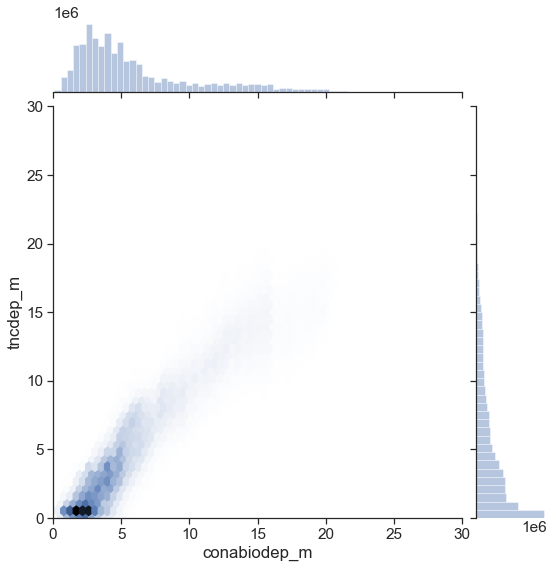

In [64]:
sns.set(style="ticks", font_scale=1.4)
# # Hex bin plot with regression and histograms
hp = sns.jointplot(x=bathy_conabio_tncMARnorth_nozero['conabiodep_m'], 
                   y=bathy_conabio_tncMARnorth_nozero['tncdep_m'],
                kind='hex', height=8,
                xlim=(0, 30), ylim=(0, 30)
                )
#  title = 'SRTM vs GLiHT Canopy height in grouped {} data'.format(sourcetext)
#  plt.title(title, loc='right')
# hp.ax_joint.text(14,24,sourcetext)
#  hp.set_axis_labels("SRTM Elevation (m)", "G-LiHT Max Height (m)", fontsize=16)
# hp.ax_joint.set_xlabel(xlabl)
# hp.ax_joint.set_ylabel(ylabl)
# hp.ax_joint.set_xticks(range(-4,20,2))
# hp.ax_joint.set_yticks(range(0,26,2))

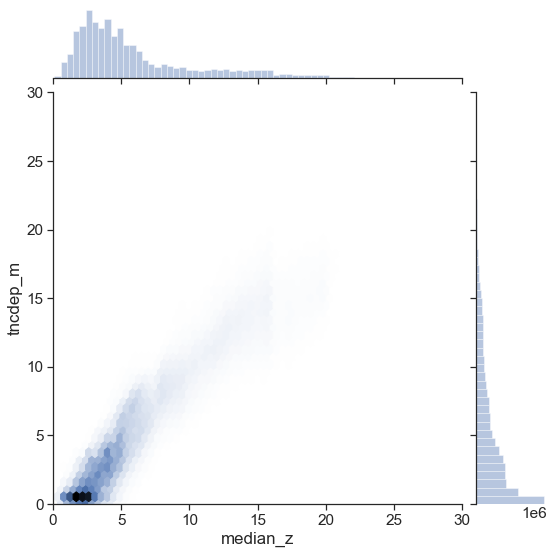

In [91]:
### Plots using Grouped CONABIO values
# Hex plot - Median
hp = sns.jointplot(x='median_z', 
                   y='tncdep_m',
                   data=grouped_conabio_tnc,
                kind='hex', height=8,
                xlim=(0, 30), ylim=(0, 30)
                )

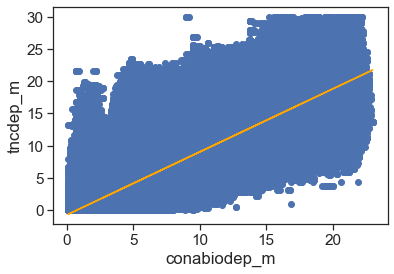

R squared: 0.8528837358658101
intercept: [-0.72562551]
slope: [[0.97560116]]
RMSE: 1.8187632448979234


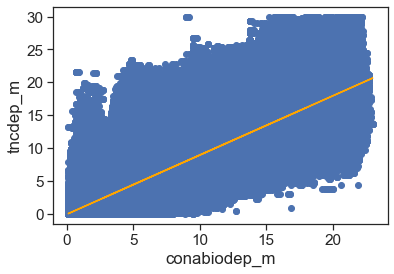

R squared: 0.8444425093538288
intercept: 0.0
slope: [[0.89798363]]
RMSE: 1.8702139386790242


In [65]:
# Linear regression & scatter plots
linear_regress(bathy_conabio_tncMARnorth_nozero, 'conabiodep_m', 'tncdep_m',  True)
linear_regress(bathy_conabio_tncMARnorth_nozero, 'conabiodep_m', 'tncdep_m',  False) # define intercept as 0

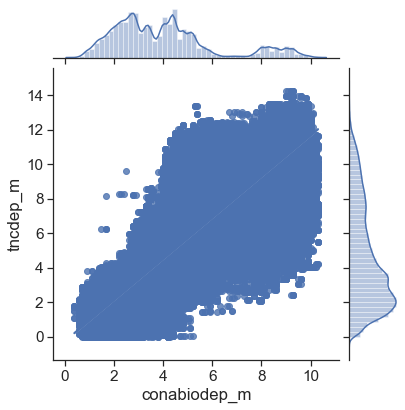

In [66]:
hp = sns.jointplot(x='conabiodep_m', y='tncdep_m', data=bathy_conabio_tncMARnorth_nozero[1:1000000], kind="reg")

CPU times: user 5h 2min 43s, sys: 1h 1min 9s, total: 6h 3min 53s
Wall time: 1h 40min


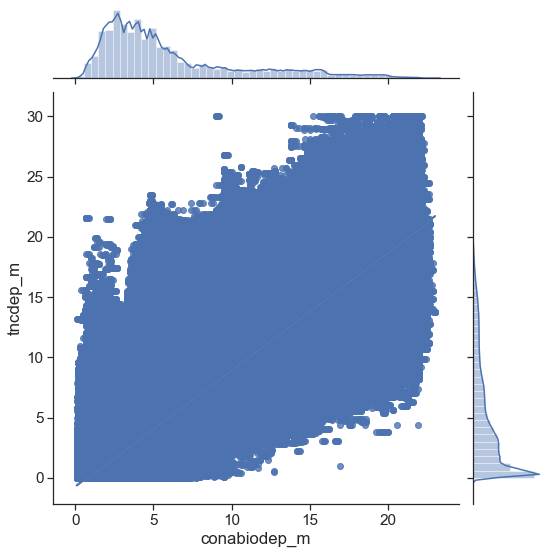

In [67]:
%time hp = sns.jointplot(x='conabiodep_m', y='tncdep_m', data=bathy_conabio_tncMARnorth_nozero, kind="reg", height=8)

CPU times: user 1h 51min 31s, sys: 4min 13s, total: 1h 55min 45s
Wall time: 12min 57s


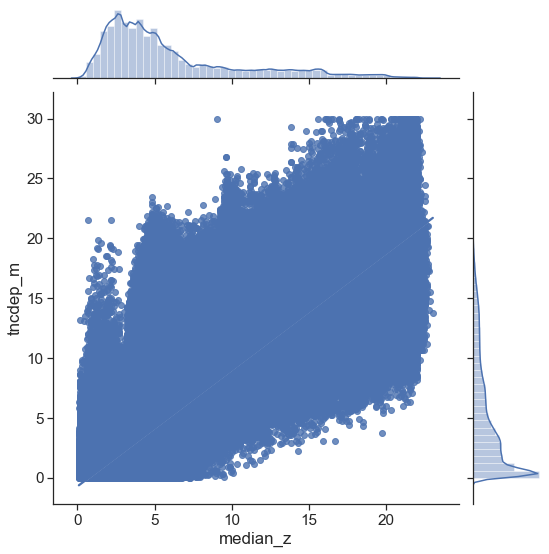

In [92]:
%time hp = sns.jointplot(x='median_z', y='tncdep_m', data=grouped_conabio_tnc, kind="reg", height=8)

# Import and Plot AGRRA depth compared to CONABIO and TNC SDB

In [69]:
agrra_gdf = gpd.read_file("bathy_agrra_tnc_conabio.shp")
agrra_gdf

,BATCH,CODE,SITE,DATE,LATITUDE,LONGITUDE,ZONE,SUBREGION,SHELF,ECOREGION,DEPTH,NT,RAVG,RSTD,RMAX,tncdep_m_1,cbdep_m_1,geometry
0,Bahamas-2007,S1-01,None,2007-10-09 00:00:00,24.7045,-77.75105,Patch,Andros,Andros Shelf,Bahamian,None,10,17.1,4.0,55,NaN,NaN,POINT (-77.75105 24.70450)
1,Bahamas-2007,S1-02,None,2007-10-11 00:00:00,24.71256,-77.74769,Fore,Andros,Andros Shelf,Bahamian,None,10,40.3,14.7,100,NaN,NaN,POINT (-77.74769 24.71256)
2,Bahamas-2007,S1-03,None,2007-10-12 00:00:00,24.71337,-77.75283,Crest,Andros,Andros Shelf,Bahamian,None,10,41.3,10.1,105,NaN,NaN,POINT (-77.75283 24.71337)
3,Bahamas-2007,S1-04,None,2007-10-10 00:00:00,24.71802,-77.76105,Patch,Andros,Andros Shelf,Bahamian,None,10,28.7,13.2,95,NaN,NaN,POINT (-77.76105 24.71802)
4,Bahamas-2007,S1-05,None,2007-10-11 00:00:00,24.72222,-77.76082,Crest,Andros,Andros Shelf,Bahamian,None,10,37.4,23.1,115,NaN,NaN,POINT (-77.76082 24.72222)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,StVincent-2015,UNI010,World's End Reef-S,2015-12-14 00:00:00,12.61022,-61.34052,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,9.8,10,29.9,6.4,80,NaN,NaN,POINT (-61.34052 12.61022)
688,StVincent-2015,UNI011,Roundabout Reef,2015-12-14 00:00:00,12.5922,-61.41135,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,10.2,10,84.6,23.7,200,NaN,NaN,POINT (-61.41135 12.59220)
689,StVincent-2015,UNI012,Petit Rameau,2015-12-15 00:00:00,12.63933,-61.35987,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,6.5,10,48.9,14.0,100,NaN,NaN,POINT (-61.35987 12.63933)
690,StVincent-2015,UNI205,World's End Reef-SE,2015-12-14 00:00:00,12.60933,-61.33109,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,10.9,9,25.0,6.0,50,NaN,NaN,POINT (-61.33109 12.60933)


In [70]:
# Some data tidying
# Set CONABIO depths to positive values
agrra_gdf['cbdep_m'] = agrra_gdf['cbdep_m_1'] * (-1)
# Make a float type for AGRRA depths
agrra_gdf['agrradep_m'] = agrra_gdf['DEPTH'].astype('float')
# Rename TNC depth column for consistency
agrra_gdf.rename(columns={"tncdep_m_1": "tncdep_m"}, inplace=True)
agrra_gdf

,BATCH,CODE,SITE,DATE,LATITUDE,LONGITUDE,ZONE,SUBREGION,SHELF,ECOREGION,DEPTH,NT,RAVG,RSTD,RMAX,tncdep_m,cbdep_m_1,geometry,cbdep_m,agrradep_m
0,Bahamas-2007,S1-01,None,2007-10-09 00:00:00,24.7045,-77.75105,Patch,Andros,Andros Shelf,Bahamian,None,10,17.1,4.0,55,NaN,NaN,POINT (-77.75105 24.70450),NaN,NaN
1,Bahamas-2007,S1-02,None,2007-10-11 00:00:00,24.71256,-77.74769,Fore,Andros,Andros Shelf,Bahamian,None,10,40.3,14.7,100,NaN,NaN,POINT (-77.74769 24.71256),NaN,NaN
2,Bahamas-2007,S1-03,None,2007-10-12 00:00:00,24.71337,-77.75283,Crest,Andros,Andros Shelf,Bahamian,None,10,41.3,10.1,105,NaN,NaN,POINT (-77.75283 24.71337),NaN,NaN
3,Bahamas-2007,S1-04,None,2007-10-10 00:00:00,24.71802,-77.76105,Patch,Andros,Andros Shelf,Bahamian,None,10,28.7,13.2,95,NaN,NaN,POINT (-77.76105 24.71802),NaN,NaN
4,Bahamas-2007,S1-05,None,2007-10-11 00:00:00,24.72222,-77.76082,Crest,Andros,Andros Shelf,Bahamian,None,10,37.4,23.1,115,NaN,NaN,POINT (-77.76082 24.72222),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,StVincent-2015,UNI010,World's End Reef-S,2015-12-14 00:00:00,12.61022,-61.34052,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,9.8,10,29.9,6.4,80,NaN,NaN,POINT (-61.34052 12.61022),NaN,9.8
688,StVincent-2015,UNI011,Roundabout Reef,2015-12-14 00:00:00,12.5922,-61.41135,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,10.2,10,84.6,23.7,200,NaN,NaN,POINT (-61.41135 12.59220),NaN,10.2
689,StVincent-2015,UNI012,Petit Rameau,2015-12-15 00:00:00,12.63933,-61.35987,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,6.5,10,48.9,14.0,100,NaN,NaN,POINT (-61.35987 12.63933),NaN,6.5
690,StVincent-2015,UNI205,World's End Reef-SE,2015-12-14 00:00:00,12.60933,-61.33109,Fore,Grenadines (SVG),Grenada Shelf,Eastern Caribbean,10.9,9,25.0,6.0,50,NaN,NaN,POINT (-61.33109 12.60933),NaN,10.9


# Compare AGRRA depths to TNC SDB depths

In [71]:
# Subset for TNC depths only
agrra_tnc_gdf = agrra_gdf[(agrra_gdf['tncdep_m'] > 0) & (agrra_gdf['agrradep_m'] > 0)]
agrra_tnc_gdf
# 239 points overlapping

,BATCH,CODE,SITE,DATE,LATITUDE,LONGITUDE,ZONE,SUBREGION,SHELF,ECOREGION,DEPTH,NT,RAVG,RSTD,RMAX,tncdep_m,cbdep_m_1,geometry,cbdep_m,agrradep_m
264,Belize-2011,BZ1037A,Carrie Caye,2011-08-13 00:00:00,16.51746,-88.19352,Fore,Southern Barrier Complex,Belize Shelf,Western Caribbean,2.7,9,37.3,7.4,120,3.666021,NaN,POINT (-88.19352 16.51746),NaN,2.7
266,Belize-2011,BZ1043,Southwater Caye,2011-08-16 00:00:00,16.63021,-88.20611,Crest,Central Barrier Complex,Belize Shelf,Western Caribbean,1.2,4,27.2,14.3,75,7.861381,NaN,POINT (-88.20611 16.63021),NaN,1.2
267,Belize-2011,BZ1044,South of Carrie Bow Caye,2011-08-16 00:00:00,16.64572,-88.0662,Fore,Central Barrier Complex,Belize Shelf,Western Caribbean,6.7,10,33.9,10.9,120,7.425933,NaN,POINT (-88.06620 16.64572),NaN,6.7
268,Belize-2011,BZ1057,West of Hat Caye,2011-12-06 00:00:00,17.1692,-87.6317,Fore,Lighthouse reef,Offshore Belize Shelf,Western Caribbean,10.2,10,79.3,44.1,280,16.052406,NaN,POINT (-87.63170 17.16920),NaN,10.2
269,Belize-2011,BZ1064,Paranga Grounding Site,2011-08-17 00:00:00,17.31848,-88.0425,Fore,Central Barrier Complex,Belize Shelf,Western Caribbean,4.1,10,34.0,32.6,230,3.815967,NaN,POINT (-88.04250 17.31848),NaN,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,Mï¿½xico-2014,MX2067,Ixcayal,2014-08-28 00:00:00,18.40018,-87.76702,Fore (Front),Southern Quintana Roo,South Yucatan Shelf,Western Caribbean,10.0,7,44.3,5.9,170,8.750115,-10.65,POINT (-87.76702 18.40018),10.65,10.0
638,Mï¿½xico-2014,MX3009,Chunchakab Bajo,2014-09-05 00:00:00,20.27226,-86.99994,Fore (Front),Cozumel,Cozumel Shelf,Western Caribbean,7.1,10,39.3,14.2,140,10.763993,NaN,POINT (-86.99994 20.27226),NaN,7.1
639,Mï¿½xico-2014,MX3021,Norte Mahahual,2014-10-10 00:00:00,18.78277,-87.65809,Fore (Front),Southern Quintana Roo,South Yucatan Shelf,Western Caribbean,13.6,10,3.0,3.7,25,14.639011,-14.24,POINT (-87.65809 18.78277),14.24,13.6
640,Mï¿½xico-2014,MXXCK01,Las Cuevitas,2014-10-11 00:00:00,18.2137,-87.82744,Fore (Front),Southern Quintana Roo,South Yucatan Shelf,Western Caribbean,10.7,10,61.7,40.5,700,13.524731,-12.08,POINT (-87.82744 18.21370),12.08,10.7


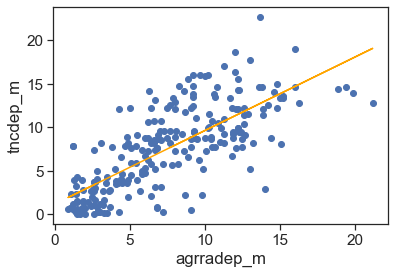

R squared: 0.5651370466362081
intercept: [1.18290091]
slope: [[0.8427862]]
RMSE: 3.2362630403089585


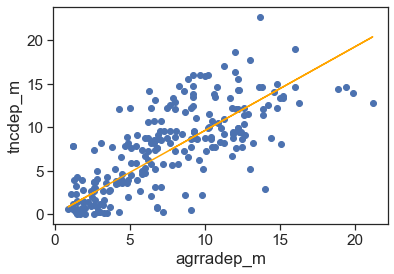

R squared: 0.5501883075151552
intercept: 0.0
slope: [[0.96091314]]
RMSE: 3.291417531725251


In [72]:
linear_regress(agrra_tnc_gdf, 'agrradep_m', 'tncdep_m',  True)
linear_regress(agrra_tnc_gdf, 'agrradep_m', 'tncdep_m',  False) # define intercept as 0

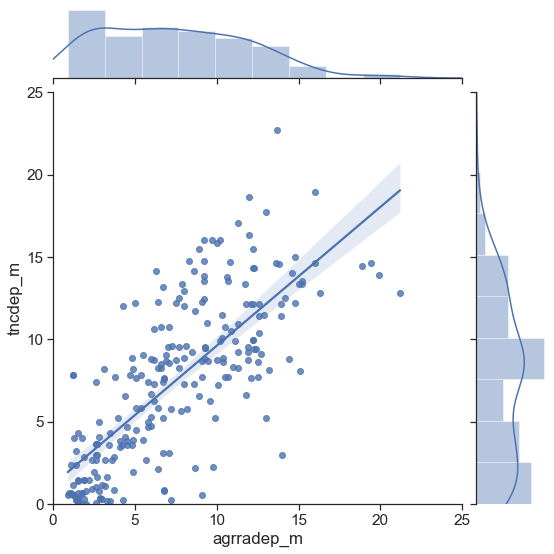

In [73]:
hp = sns.jointplot(x='agrradep_m', y='tncdep_m', 
                   data=agrra_tnc_gdf, height=8, kind="reg",
                  xlim=(0, 25), ylim=(0, 25))

# Compare AGRRA to CONABIO SDB depths

In [74]:
# Subset for CONABIO depths only
agrra_conabio_gdf = agrra_gdf[(agrra_gdf['cbdep_m'] > 0) & (agrra_gdf['agrradep_m'] > 0)]
agrra_conabio_gdf.describe()
# Only 44 points overlapping

,tncdep_m,cbdep_m_1,cbdep_m,agrradep_m
count,44.000000,44.000000,44.000000,44.000000
mean,7.909410,-8.776591,8.776591,7.550000
std,5.492403,5.217907,5.217907,4.510943
min,0.015774,-17.100000,0.350000,1.000000
25%,1.960641,-12.225000,3.275000,2.900000
50%,9.167689,-10.270000,10.270000,7.950000
75%,11.894824,-3.275000,12.225000,10.325000
max,18.656065,-0.350000,17.100000,19.400000


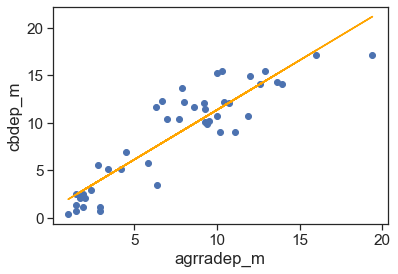

R squared: 0.8192158154877293
intercept: [0.87207768]
slope: [[1.0469554]]
RMSE: 2.1932313236385252


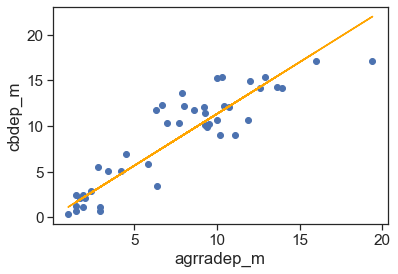

R squared: 0.8118233356576225
intercept: 0.0
slope: [[1.13258816]]
RMSE: 2.2376239691309925


In [75]:
linear_regress(agrra_conabio_gdf, 'agrradep_m', 'cbdep_m',  True)
linear_regress(agrra_conabio_gdf, 'agrradep_m', 'cbdep_m',  False) # define intercept as 0

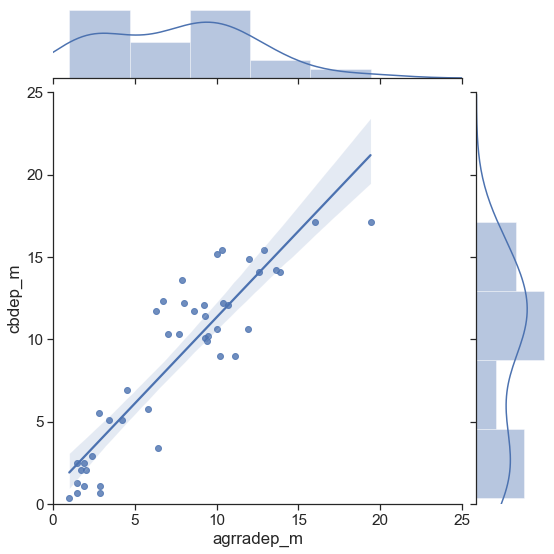

In [76]:
hp = sns.jointplot(x='agrradep_m', y='cbdep_m', 
                   data=agrra_tnc_gdf, height=8, kind="reg",
                  xlim=(0, 25), ylim=(0, 25))